In [10]:
# 导入库文件
import pandas as pd 
from sklearn.model_selection import train_test_split

In [11]:
# 读入数据
filepath_dict = {'yelp':   './data/yelp_labelled.txt',
                 'amazon': './data/amazon_cells_labelled.txt',
                 'imdb':   './data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)
    
df = pd.concat(df_list)

In [12]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [13]:
# 切分数据集
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_valid, y_train, y_valid = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

In [15]:
# 构建并训练CountVectorizer词袋模型
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_valid  = vectorizer.transform(sentences_valid)

In [17]:
# 使用逻辑回归来对词袋模型CountVectorizer进行预测
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_valid, y_valid)

print("Accuracy:", score)

Accuracy: 0.796


In [18]:
# 应用到所有数据集，注意本次针对每一个类别，分别训练了一个词袋模型和LR模型
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values
    
    sentences_train, sentences_valid, y_train, y_valid = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_valid  = vectorizer.transform(sentences_valid)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_valid, y_valid)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


In [19]:
X_valid.shape

(187, 2505)

In [20]:
X_train.shape

(561, 2505)

In [21]:
# # 词袋模型 CountVectorizer  (一个小例子)
# from sklearn.feature_extraction.text import CountVectorizer

# sentences = ['John likes ice cream John', 'John hates chocolate.']

# vectorizer = CountVectorizer(analyzer='word', min_df=0, lowercase=True)
# vectorizer.fit(sentences)
# # CountVectorizer训练将出现的每一个词建立索引并计算频次,注意，频次是指在1篇文档下的频次！
# print(vectorizer.vocabulary_)
# # CountVectorizer将出现的句子根据对应的索引和词频进行向量化表示
# print(vectorizer.transform(sentences).toarray())

In [22]:
# 构建一个keras模型
from keras.models import Sequential
from keras import layers 

input_dim = X_train.shape[1] # number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(X_train, y_train,epochs=20, batch_size=10, verbose=1, validation_data=(X_valid, y_valid))

Train on 561 samples, validate on 187 samples
Epoch 1/20
561/561 [==============================] - 0s 728us/step - loss: 0.6932 - acc: 0.5312 - val_loss: 0.6911 - val_acc: 0.5936
Epoch 2/20
561/561 [==============================] - 0s 228us/step - loss: 0.6359 - acc: 0.7914 - val_loss: 0.6634 - val_acc: 0.6631
Epoch 3/20
561/561 [==============================] - 0s 232us/step - loss: 0.5651 - acc: 0.9002 - val_loss: 0.6306 - val_acc: 0.7005
Epoch 4/20
561/561 [==============================] - 0s 234us/step - loss: 0.4719 - acc: 0.9554 - val_loss: 0.5942 - val_acc: 0.7273
Epoch 5/20
561/561 [==============================] - 0s 237us/step - loss: 0.3780 - acc: 0.9697 - val_loss: 0.5633 - val_acc: 0.7433
Epoch 6/20
561/561 [==============================] - 0s 241us/step - loss: 0.3000 - acc: 0.9840 - val_loss: 0.5241 - val_acc: 0.7701
Epoch 7/20
561/561 [==============================] - 0s 232us/step - loss: 0.2407 - acc: 0.9857 - val_loss: 0.5116 - val_acc: 0.7540
Epoch 8/20
561/5

In [24]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=1)
print('Training Accuracy:', accuracy)
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=1)
print('Valid Accuracy:', accuracy)

561/561 [==============================] - 0s 61us/step
Training Accuracy: 0.9982174688057041
187/187 [==============================] - 0s 75us/step
Valid Accuracy: 0.7807486627828628


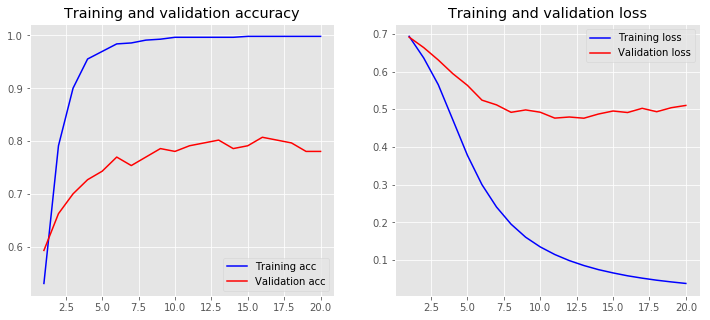

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

## 词嵌入

- 使用CountVectorizer，每个向量的长度相同，等于总语料库的大小，其中的值表示该词在这句话中的出现次数。
- 使用Tokenizer，每个向量等于每个文本的长度，其数值并不表示计数，而是对应于字典tokenizer.word_index中的单词值。

In [46]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_valid = tokenizer.texts_to_sequences(sentences_valid)

# vocabsize一定程度代表了tokenizer的一个值最大有可能是多少
vocab_size = len(tokenizer.word_index) + 1
# tokenizer把每一个词转化成了一个字典的key，这样就把一句话进行了稠密表示，然而这种方式并不能表征词与词之间的关系
print(sentences_train[0])
print(X_train[0])

# 可以看到'out'对应的Value为35
print(tokenizer.word_index)

Definitely worth checking out.  
[170, 116, 390, 35]
{'the': 1, 'a': 2, 'and': 3, 'of': 4, 'is': 5, 'this': 6, 'i': 7, 'it': 8, 'to': 9, 'in': 10, 'movie': 11, 'was': 12, 'film': 13, 'that': 14, '0': 15, 'for': 16, 'as': 17, '1': 18, 'but': 19, 'with': 20, 'not': 21, 'are': 22, 'on': 23, "it's": 24, 'one': 25, 'you': 26, 'all': 27, 'so': 28, 'just': 29, 'bad': 30, 'at': 31, 'very': 32, 'good': 33, 'an': 34, 'out': 35, 'there': 36, 'be': 37, 'by': 38, 'time': 39, 'like': 40, 'have': 41, 'or': 42, 'about': 43, 'great': 44, 'really': 45, 'from': 46, 'even': 47, 'characters': 48, 'his': 49, 'who': 50, 'if': 51, 'more': 52, 'see': 53, 'acting': 54, 'were': 55, '10': 56, 'has': 57, 'my': 58, 'some': 59, 'well': 60, 'only': 61, 'no': 62, 'he': 63, 'because': 64, 'most': 65, 'when': 66, "don't": 67, 'its': 68, 'how': 69, 'story': 70, 'movies': 71, 'best': 72, 'other': 73, "didn't": 74, 'plot': 75, 'character': 76, 'can': 77, 'also': 78, 'than': 79, 'real': 80, 'up': 81, 'ever': 82, 'seen': 83,

- 为了解决Tokenizer使向量长度不等的问题，可以使用pad_sequence()用零填充单词序列，还需要添加maxlen参数来制定序列的长度。

In [63]:
from keras.preprocessing.sequence import pad_sequences
# maxlen一定程度代表了这句话最长可能由多少个单词组成
maxlen = 100 
print(sentences_train[:2])
#首先看一下X_train,此时由每句话转成的向量长度不等
print(X_train[:2])

# 使用pad_sequence()进行补齐,maxlen控制补齐后的长度
print('开始填充序列...')
X_train = pad_sequences(X_train, maxlen=100)
X_valid = pad_sequences(X_valid, maxlen=100)
print(X_train[:2])

['Definitely worth checking out.  ' 'I keep watching it over and over.  ']
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0 170 116 390  35]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   7 310  97   8 117   3 117]]
开始填充序列...
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 

In [72]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# 让每一个词由50维的稠密向量表示，这样我们就由不可学习的tokenizer稠密表示
# 变为可学习的embedding稠密表示
embedding_dim = 50 

model = Sequential()

# 构建嵌入层，注意各参数对应的指标
model.add(Embedding(input_dim=vocab_size,     # 词典大小，每一个值的最大值
                    output_dim=embedding_dim, # 每一个词用多大维度的稠密向量来表示
                    input_length=maxlen))     # 输入层的维度
# 将嵌入层平铺的展开层
model.add(Flatten())
# 是个神经元的隐藏层
model.add(Dense(10, activation='relu'))
# 激活函数为sigmoid的输出层
model.add(Dense(1, activation='sigmoid'))

# 编译模型，设定优化器，损失函数，评估指标
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 查看一下该模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
flatten_7 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                50010     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


Train on 561 samples, validate on 187 samples
Epoch 1/10
561/561 [==============================] - 1s 1ms/step - loss: 0.6946 - acc: 0.4635 - val_loss: 0.6932 - val_acc: 0.4920
Epoch 2/10
561/561 [==============================] - 0s 455us/step - loss: 0.6887 - acc: 0.5276 - val_loss: 0.6974 - val_acc: 0.4866
Epoch 3/10
561/561 [==============================] - 0s 458us/step - loss: 0.6568 - acc: 0.5312 - val_loss: 0.6840 - val_acc: 0.4920
Epoch 4/10
561/561 [==============================] - 0s 474us/step - loss: 0.4703 - acc: 0.8841 - val_loss: 0.6088 - val_acc: 0.6417
Epoch 5/10
561/561 [==============================] - 0s 567us/step - loss: 0.1693 - acc: 0.9840 - val_loss: 0.5663 - val_acc: 0.6791
Epoch 6/10
561/561 [==============================] - 0s 444us/step - loss: 0.0540 - acc: 1.0000 - val_loss: 0.5657 - val_acc: 0.7059
Epoch 7/10
561/561 [==============================] - 0s 478us/step - loss: 0.0242 - acc: 1.0000 - val_loss: 0.5703 - val_acc: 0.7166
Epoch 8/10
561/561

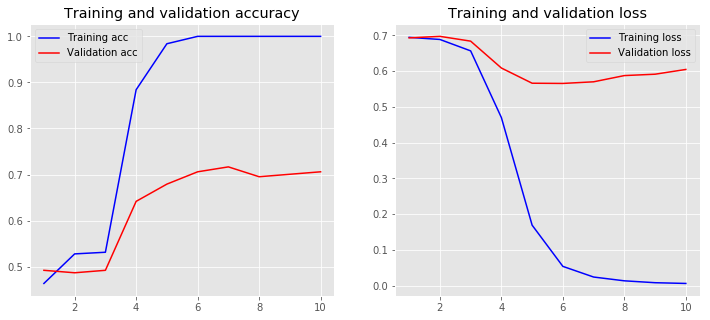

In [73]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    verbose=1,                    
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [76]:
# 添加池化层
from keras.models import Sequential
from keras.layers import Embedding, GlobalMaxPool1D, Dense

embedding_dim = 50 

model = Sequential() 
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Train on 561 samples, validate on 187 samples
Epoch 1/10
561/561 [==============================] - 1s 1ms/step - loss: 0.6906 - acc: 0.5258 - val_loss: 0.6922 - val_acc: 0.4866
Epoch 2/10
561/561 [==============================] - 0s 567us/step - loss: 0.6758 - acc: 0.5508 - val_loss: 0.6865 - val_acc: 0.5080
Epoch 3/10
561/561 [==============================] - 0s 533us/step - loss: 0.6414 - acc: 0.6898 - val_loss: 0.6639 - val_acc: 0.6471
Epoch 4/10
561/561 [==============================] - 0s 548us/step - loss: 0.5629 - acc: 0.9144 - val_loss: 0.6201 - val_acc: 0.6952
Epoch 5/10
561/561 [==============================] - 0s 523us/step - loss: 0.4294 - acc: 0.9519 - val_loss: 0.5596 - val_acc: 0.7487
Epoch 6/10
561/561 [==============================] - 0s 542us/step - loss: 0.2795 - acc: 0.9750 - val_loss: 0.5055 - val_acc: 0.7540
Epoch 7/10
561/561 [==============================] - 0s 524us/step - loss: 0.1692 - acc: 0.9893 - val_loss: 0.4824 - val_acc: 0.7754
Epoch 8/10
561/561

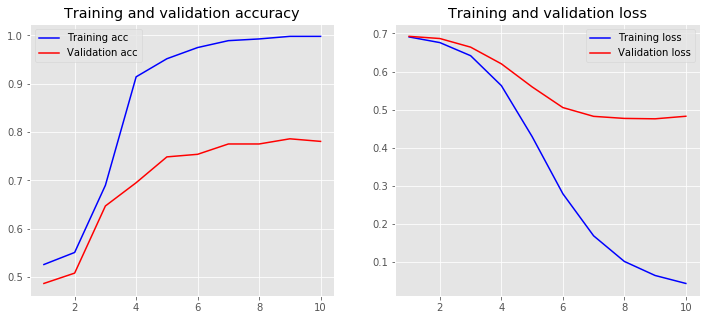

In [77]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    verbose=1,                    
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## 使用预训练的词嵌入

- word2vec 效果好，使用神经网络实现
- Glove 速度快，通过共生矩阵实现
- Gensim 自定义

In [88]:
# 练习使用Glove
# 首先下载词嵌入,并针对word_index中出现的词做筛选
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='UTF-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [89]:
# 创建嵌入矩阵
embedding_dim = 50
embedding_matrix = create_embedding_matrix('./data/glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [ ]:
# 我们可以选择更新参数和不更新参数两种方式
nonzero_element

In [91]:
# 查看一下嵌入矩阵的维度(词表长度 * 设定嵌入维度)
embedding_matrix.shape

(2575, 50)

In [129]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('{}%的向量是非零的,被预训练的词嵌入模型覆盖'.format(round((nonzero_elements / vocab_size) * 100,2)))

95.22%的向量是非零的,被预训练的词嵌入模型覆盖


In [138]:
model = Sequential() 
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim,
                    input_length=maxlen,
                    weights=[embedding_matrix], # 将词嵌入矩阵赋值给嵌入层
                    trainable=False))            # 参数不可更新    
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


Train on 561 samples, validate on 187 samples
Epoch 1/50
561/561 [==============================] - 1s 1ms/step - loss: 0.6971 - acc: 0.5294 - val_loss: 0.7027 - val_acc: 0.5080
Epoch 2/50
561/561 [==============================] - 0s 205us/step - loss: 0.6849 - acc: 0.5401 - val_loss: 0.6873 - val_acc: 0.5508
Epoch 3/50
561/561 [==============================] - 0s 200us/step - loss: 0.6665 - acc: 0.5936 - val_loss: 0.6751 - val_acc: 0.6043
Epoch 4/50
561/561 [==============================] - 0s 169us/step - loss: 0.6550 - acc: 0.6328 - val_loss: 0.6691 - val_acc: 0.5989
Epoch 5/50
561/561 [==============================] - 0s 162us/step - loss: 0.6494 - acc: 0.6221 - val_loss: 0.6619 - val_acc: 0.6043
Epoch 6/50
561/561 [==============================] - 0s 162us/step - loss: 0.6360 - acc: 0.6435 - val_loss: 0.6475 - val_acc: 0.6631
Epoch 7/50
561/561 [==============================] - 0s 202us/step - loss: 0.6235 - acc: 0.6560 - val_loss: 0.6613 - val_acc: 0.5882
Epoch 8/50
561/561

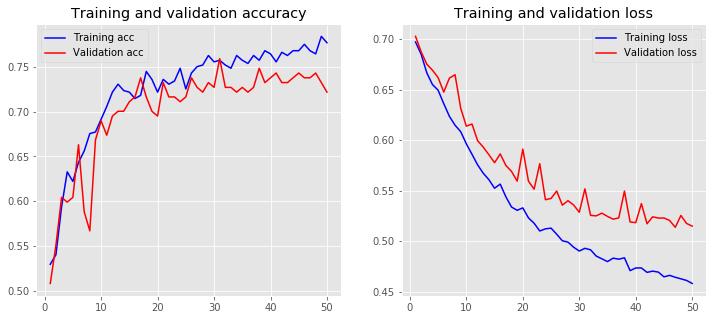

In [139]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_valid, y_valid),
                    verbose=1,                    
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [140]:
# 再试下fine tuning更新词嵌入模型
model = Sequential() 
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim,
                    input_length=maxlen,
                    weights=[embedding_matrix], # 将词嵌入矩阵赋值给嵌入层
                    trainable=True))            # 参数不可更新    
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Train on 561 samples, validate on 187 samples
Epoch 1/50
561/561 [==============================] - 1s 2ms/step - loss: 0.7306 - acc: 0.5526 - val_loss: 0.6935 - val_acc: 0.5508
Epoch 2/50
561/561 [==============================] - 0s 685us/step - loss: 0.6555 - acc: 0.6132 - val_loss: 0.6666 - val_acc: 0.6043
Epoch 3/50
561/561 [==============================] - 0s 792us/step - loss: 0.6127 - acc: 0.6791 - val_loss: 0.6511 - val_acc: 0.6310
Epoch 4/50
561/561 [==============================] - 1s 917us/step - loss: 0.5787 - acc: 0.7255 - val_loss: 0.6346 - val_acc: 0.6791
Epoch 5/50
561/561 [==============================] - 0s 696us/step - loss: 0.5363 - acc: 0.7825 - val_loss: 0.6090 - val_acc: 0.7005
Epoch 6/50
561/561 [==============================] - 0s 788us/step - loss: 0.4966 - acc: 0.8146 - val_loss: 0.6017 - val_acc: 0.7059
Epoch 7/50
561/561 [==============================] - 1s 892us/step - loss: 0.4547 - acc: 0.8431 - val_loss: 0.5736 - val_acc: 0.7326
Epoch 8/50
561/561

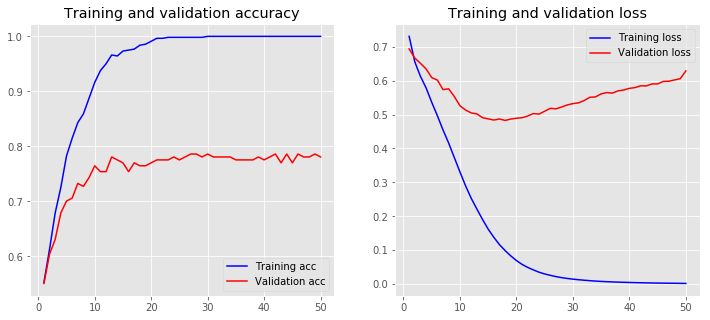

In [141]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_valid, y_valid),
                    verbose=1,                    
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# Text CNN 

In [144]:
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
model = Sequential() 
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           128750    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 162,179
Trainable params: 162,179
Non-trainable params: 0
_________________________________________________________________


Train on 561 samples, validate on 187 samples
Epoch 1/50
561/561 [==============================] - 2s 3ms/step - loss: 0.6932 - acc: 0.4831 - val_loss: 0.6931 - val_acc: 0.5080
Epoch 2/50
561/561 [==============================] - 1s 2ms/step - loss: 0.6809 - acc: 0.6078 - val_loss: 0.6844 - val_acc: 0.5348
Epoch 3/50
561/561 [==============================] - 1s 2ms/step - loss: 0.5734 - acc: 0.7611 - val_loss: 0.5981 - val_acc: 0.7219
Epoch 4/50
561/561 [==============================] - 1s 2ms/step - loss: 0.2504 - acc: 0.9430 - val_loss: 0.5341 - val_acc: 0.7647
Epoch 5/50
561/561 [==============================] - 1s 2ms/step - loss: 0.0489 - acc: 0.9982 - val_loss: 0.5761 - val_acc: 0.7861
Epoch 6/50
561/561 [==============================] - 1s 2ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.6527 - val_acc: 0.7754
Epoch 7/50
561/561 [==============================] - 1s 2ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.6967 - val_acc: 0.7754
Epoch 8/50
561/561 [==========

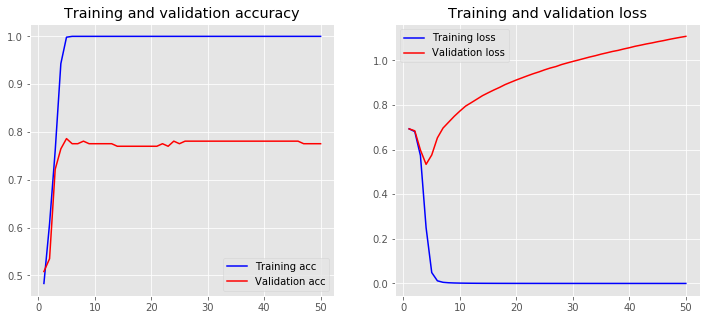

In [146]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_valid, y_valid),
                    verbose=1,                    
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [153]:
# 使用随机搜索调节参数，为了让keras可以应用sklearn中的随机搜索
# 需要将keras包装成KerasClassifier
def Create_model(num_filters, kernel_size, vocab_size, maxlen):
    model = Sequential() 
    model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [154]:
param_grid = dict(num_filters=[64, 128],
                  kernel_size=[5, 7],
                  vocab_size=[5000],
                  embedding_dim=[50],
                  maxlen=[100])

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings 
epochs = 20 
embedding_dim = 50
maxlen = 100 
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, fram in df.groupby('source'):
    print('Running grid search for dataset:', source)
    sentences = df['sentence'].values
    y = df['label'].values
    
    # Train test split
    sentences_train, sentences_valid, y_train, y_valid = train_test_split(sentences, y, test_size=0.25, random_state=1000)
    
    # Tokenize words 
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_valid = tokenizer.texts_to_sequences(sentences_train)
    
    # Adding 1 because of 0 in index
    vocab_size = len(tokenizer.word_index) + 1 
    
    # Pad sequences with zeros 
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)  # padding 在起始补还是在结尾补,truncating当需要截断序列时，从起始还是结尾截断
    X_valid = pad_sequences(X_valid, padding='post', maxlen=maxlen)
    
    # Parameter grid for grid search 
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[1, 3, 5, 7],
                      vocab_size=[vocab_size],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=Create_model,
                            epochs=10, 
                            batch_size=10,
                            verbose=True)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,cv=2, verbose=1)
    grid_result = grid.fit(X_train, y_train)
    
    # Evaluate testing set 
    valid_accuracy = grid.score(X_valid, y_valid)
    
        # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nValid Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            valid_accuracy)
        print(output_string)
        f.write(output_string)
    